In [1]:
import os
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from statsmodels.graphics.tsaplots import plot_predict, plot_acf, plot_pacf
from sklearn.utils import shuffle
import math
from scipy import stats


In [2]:
data = pd.read_csv('/Users/_fangkhai/Documents/Computer Science Semester 5/Introduction to Data Science/Assignment Dataset/INFY Historical Data.csv').fillna(0)
data["Date"] = pd.to_datetime(data.Date)
data.set_index ("Date", inplace = True)
data.dtypes

Price       object
Open        object
High        object
Low         object
Vol.        object
Change %    object
dtype: object

In [3]:
data

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2020-12-31,"1,255.80","1,243.00","1,258.40","1,239.00",7.43M,0.72%
2020-12-30,"1,246.80","1,253.00","1,253.30","1,238.15",5.19M,-0.28%
2020-12-29,"1,250.30","1,235.00","1,254.45","1,235.00",6.88M,0.81%
2020-12-28,"1,240.30","1,238.45","1,248.00","1,236.00",4.61M,0.34%
2020-12-24,"1,236.05","1,249.90","1,249.90","1,226.00",7.31M,-1.36%
...,...,...,...,...,...,...
2005-01-07,127.17,126.19,128.05,123.71,33.50M,0.35%
2005-01-06,126.73,126.58,129.85,123.90,27.03M,-0.43%
2005-01-05,127.28,128.05,128.98,124.09,22.20M,-1.79%


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3968 entries, 2020-12-31 to 2005-01-03
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Price     3968 non-null   object
 1   Open      3968 non-null   object
 2   High      3968 non-null   object
 3   Low       3968 non-null   object
 4   Vol.      3968 non-null   object
 5   Change %  3968 non-null   object
dtypes: object(6)
memory usage: 217.0+ KB


In [5]:
data["Price"] = data["Price"].str.replace(",", "")
data["Open"] = data["Open"].str.replace(",", "")
data["High"] = data["High"].str.replace(",", "")
data["Low"] = data["Low"].str.replace(",", "")
data["Vol."] = data["Vol."].str.replace("M", "")
data["Change %"] = data["Change %"].str.replace("%", "")

In [6]:
data['Price'] = pd.to_numeric(data['Price'], errors='coerce')
data['Open'] = pd.to_numeric(data['Open'], errors='coerce')
data['High'] = pd.to_numeric(data['High'], errors='coerce')
data['Low'] = pd.to_numeric(data['Low'], errors='coerce')
data['Vol.'] = pd.to_numeric(data['Vol.'], errors='coerce')
data['Change %'] = pd.to_numeric(data['Change %'], errors='coerce')

<AxesSubplot:>

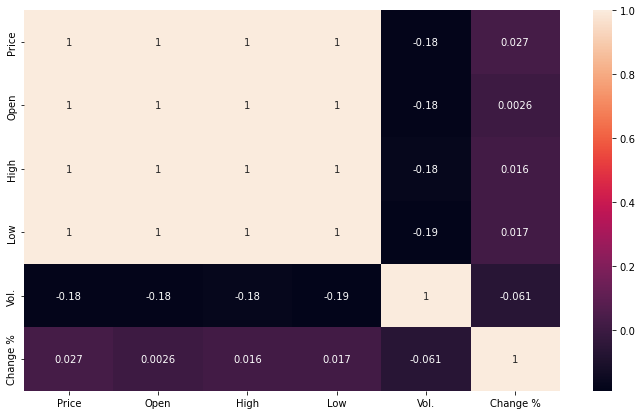

In [7]:
corr = data.corr()
plt.figure(figsize = (12, 7))
sns.heatmap(corr, annot = True)

In [8]:
data.isnull().sum()

Price        0
Open         0
High         0
Low          0
Vol.        19
Change %     0
dtype: int64

In [9]:
data.dtypes

Price       float64
Open        float64
High        float64
Low         float64
Vol.        float64
Change %    float64
dtype: object

In [10]:
data = data.fillna(data["Vol."].mean())

In [11]:
data.isnull().sum()

Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64

In [12]:
z = np.abs(stats.zscore(data))
z

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2020-12-31,4.011795,3.952192,3.961247,3.994128,0.377125,0.331705
2020-12-30,3.968926,3.999841,3.937196,3.990039,0.647224,0.183571
2020-12-29,3.985597,3.914072,3.942619,3.974887,0.443444,0.378080
2020-12-28,3.937966,3.930511,3.912202,3.979697,0.717160,0.135900
2020-12-24,3.917722,3.985070,3.921162,3.931595,0.391595,0.740069
...,...,...,...,...,...,...
2005-01-07,1.364090,1.369354,1.369411,1.370711,2.766393,0.141053
2005-01-06,1.366186,1.367496,1.360922,1.369798,1.986241,0.260862
2005-01-05,1.363566,1.360491,1.365025,1.368884,1.403840,0.961637


In [13]:
(np.abs(stats.zscore(data)) > 3).sum()

Price       61
Open        60
High        61
Low         59
Vol.        53
Change %    60
dtype: int64

In [14]:
data_clean = data[((np.abs(stats.zscore(data)))<3).all(axis=1)]
data_clean

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2020-10-01,1017.65,1020.60,1026.50,1011.75,5.56,0.93
2020-09-30,1008.25,1009.00,1023.95,1005.00,8.05,-0.07
2020-09-29,1009.00,1018.00,1028.00,1004.10,8.71,-0.14
2020-09-28,1010.40,1014.80,1016.15,998.50,8.55,-0.10
2020-09-25,1011.45,975.80,1014.90,975.00,13.31,3.70
...,...,...,...,...,...,...
2005-01-07,127.17,126.19,128.05,123.71,33.50,0.35
2005-01-06,126.73,126.58,129.85,123.90,27.03,-0.43
2005-01-05,127.28,128.05,128.98,124.09,22.20,-1.79


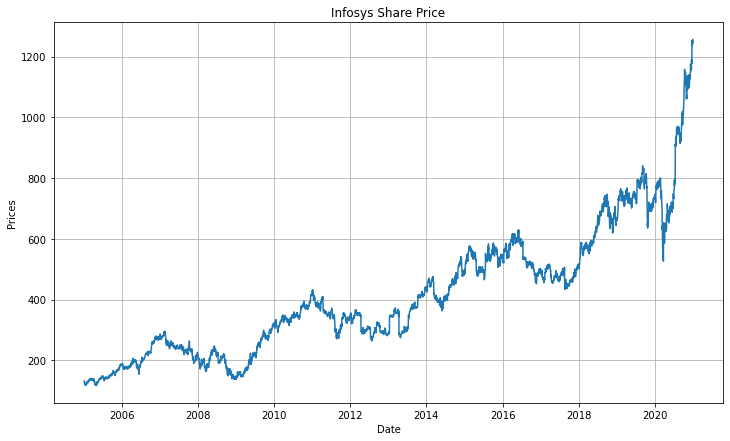

In [15]:
plt.figure(figsize=(12,7))
plt.grid(True)
plt.xlabel("Date")
plt.ylabel("Prices")
plt.plot(data["Price"])
plt.title("Infosys Share Price")
plt.show()

<AxesSubplot:ylabel='Density'>

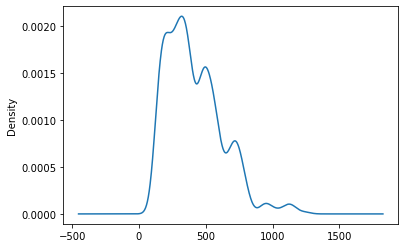

In [16]:
df = data["Price"]
df.plot(kind = "kde")

### SelectKBest

In [17]:
open_price_crosstab = pd.crosstab(data["Open"], data["Price"], margins = True)
open_price_crosstab

Price,117.0,117.91,118.16,118.17,118.21,118.6,118.62,118.68,118.7,118.76,...,1177.3,1189.8,1220.5,1236.05,1240.3,1246.8,1250.3,1253.05,1255.8,All
Open,,,,,,,,,,,,,,,,,,,,,
117.63,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
117.82,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
118.38,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
118.44,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
118.75,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1238.45,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1243.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1249.9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [18]:
high_price_crosstab = pd.crosstab(data["High"], data["Price"], margins = True)
high_price_crosstab

Price,117.0,117.91,118.16,118.17,118.21,118.6,118.62,118.68,118.7,118.76,...,1177.3,1189.8,1220.5,1236.05,1240.3,1246.8,1250.3,1253.05,1255.8,All
High,,,,,,,,,,,,,,,,,,,,,
118.75,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
119.0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
119.18,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
119.37,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
119.99,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253.3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1254.45,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1258.4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


In [19]:
low_price_crosstab = pd.crosstab(data["Low"], data["Price"], margins = True)
low_price_crosstab

Price,117.0,117.91,118.16,118.17,118.21,118.6,118.62,118.68,118.7,118.76,...,1177.3,1189.8,1220.5,1236.05,1240.3,1246.8,1250.3,1253.05,1255.8,All
Low,,,,,,,,,,,,,,,,,,,,,
116.28,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
116.36,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
116.45,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
116.7,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
117.2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1235.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1236.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1238.15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [20]:
vol_price_crosstab = pd.crosstab(data["Vol."], data["Price"], margins = True)
vol_price_crosstab

Price,117.0,117.91,118.16,118.17,118.21,118.6,118.62,118.68,118.7,118.76,...,1177.3,1189.8,1220.5,1236.05,1240.3,1246.8,1250.3,1253.05,1255.8,All
Vol.,,,,,,,,,,,,,,,,,,,,,
1.09,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1.23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1.42,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1.48,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1.7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92.85,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
98.03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
164.4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [21]:
change_price_crosstab = pd.crosstab(data["Change %"], data["Price"], margins = True)
change_price_crosstab

Price,117.0,117.91,118.16,118.17,118.21,118.6,118.62,118.68,118.7,118.76,...,1177.3,1189.8,1220.5,1236.05,1240.3,1246.8,1250.3,1253.05,1255.8,All
Change %,,,,,,,,,,,,,,,,,,,,,
-21.26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
-16.19,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
-13.4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
-12.66,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
-10.04,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11.13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12.03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
13.02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [22]:
shuffled_data = shuffle(data, random_state = 800)

#X = Independent Variable
target_col = "Price"
X = data.drop("Price", axis = 1)

#y = Dependent Variable
y = shuffled_data[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 800)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3174, 5) (794, 5) (3174,) (794,)


In [23]:
X_n = SelectKBest(f_classif, k = 1).fit_transform(X, y)
X_n.shape

#Another method (Giving Same Results)

X_new = SelectKBest(f_classif, k = 1).fit(X_train, y_train)
X_train.columns[X_new.get_support()]

Index(['Low'], dtype='object')

In [24]:
pd.crosstab(np.squeeze(X_n), np.squeeze(y))

Price,117.00,117.91,118.16,118.17,118.21,118.60,118.62,118.68,118.70,118.76,...,1175.20,1177.30,1189.80,1220.50,1236.05,1240.30,1246.80,1250.30,1253.05,1255.80
row_0,,,,,,,,,,,,,,,,,,,,,
116.28,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
116.36,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
116.45,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
116.70,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
117.20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230.55,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1235.00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1236.00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
data = data.groupby("Date").sum()

In [26]:
data = data.resample(rule = 'MS').sum()

In [27]:
data.head(10)

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2005-01-01,2352.36,2369.36,2416.32,2312.63,444.13,-0.69
2005-02-01,2634.80,2631.08,2658.07,2599.79,284.87,8.16
2005-03-01,3013.97,3015.34,3049.32,2976.80,259.22,0.98
2005-04-01,2533.99,2553.12,2583.44,2501.42,372.82,-17.44
2005-05-01,2845.35,2819.40,2874.05,2796.44,376.74,17.92
2005-06-01,3257.01,3245.84,3294.02,3213.51,321.51,4.95
2005-07-01,2809.92,2824.55,2854.74,2777.95,337.80,-3.52
2005-08-01,3133.15,3129.84,3164.64,3096.35,263.07,4.83
2005-09-01,3180.19,3179.49,3213.31,3143.01,244.24,5.94


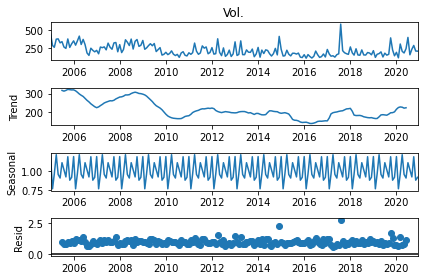

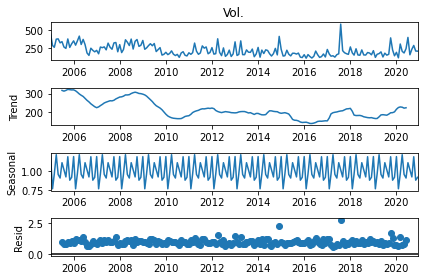

In [28]:
result = seasonal_decompose(data["Vol."], model = "multiplicable", period = 12)
result.plot()

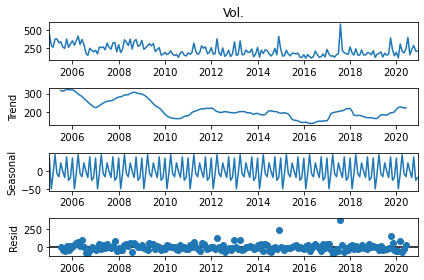

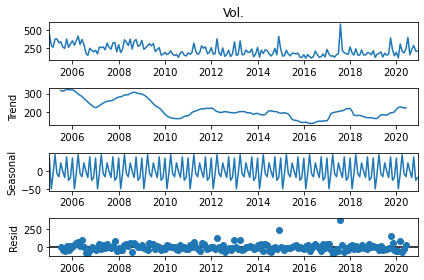

In [29]:
result = seasonal_decompose(data["Vol."], model = "additive", period = 12)
result.plot()

In [30]:
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

In [31]:
model = ExponentialSmoothing(train["Vol."], trend = "mul", seasonal = "add", seasonal_periods = 12).fit()

In [32]:
test_pred = model.forecast(39)

In [33]:
test_pred

2017-10-01    275.110442
2017-11-01    221.863280
2017-12-01    246.498374
2018-01-01    289.305459
2018-02-01    200.020247
2018-03-01    221.954686
2018-04-01    275.571236
2018-05-01    234.144913
2018-06-01    234.335868
2018-07-01    269.036130
2018-08-01    305.754966
2018-09-01    222.447050
2018-10-01    262.730105
2018-11-01    209.535141
2018-12-01    234.222213
2019-01-01    277.081057
2019-02-01    187.847386
2019-03-01    209.833147
2019-04-01    263.500804
2019-05-01    222.125372
2019-06-01    222.367005
2019-07-01    257.117730
2019-08-01    293.886816
2019-09-01    210.628939
2019-10-01    250.961821
2019-11-01    197.816474
2019-12-01    222.552955
2020-01-01    265.460998
2020-02-01    176.276320
2020-03-01    198.310867
2020-04-01    252.027105
2020-05-01    210.700048
2020-06-01    210.989852
2020-07-01    245.788545
2020-08-01    282.605397
2020-09-01    199.395085
2020-10-01    239.775332
2020-11-01    186.677149
2020-12-01    211.460595
Freq: MS, dtype: float64

<AxesSubplot:xlabel='Date'>

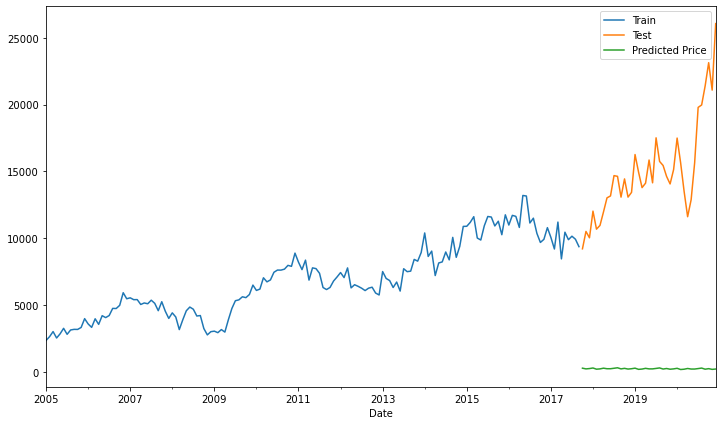

In [34]:
train["Price"].plot(legend = True, label = "Train", figsize = (12, 7))
test["Price"].plot(legend = True, label = "Test")
test_pred.plot(legend = True, label = "Predicted Price")

In [35]:
mape = np.mean(np.abs((test["Price"] - test_pred) / test["Price"])) * 100
mape

98.3398227263884

In [36]:
mae = mean_absolute_error(test["Price"], test_pred)
mae

14755.079053605166

In [37]:
mse = mean_squared_error(test["Price"], test_pred)
rmse = math.sqrt(mse)
rmse

15185.75890526375

### Final Model Built Based On Entire DataSet (Extra)

In [38]:
# final_model = ExponentialSmoothing(data["Price"], trend = "add", seasonal = "mul", seasonal_periods = 24).fit()

In [39]:
# pred = final_model.forecast(5)

In [40]:
# pred

In [41]:
# data["Price"].plot(legend = True, label = "Price", figsize = (12, 7))
# pred.plot(legend = True, label = "Predicted Price")